<a href="https://www.kaggle.com/code/hoanganh4511/text-classification-using-lstm?scriptVersionId=124538512" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from sklearn.utils import resample

In [2]:
df = pd.read_csv("/kaggle/input/emotions-in-text/Emotion_final.csv")

In [3]:
df.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


<AxesSubplot:xlabel='Emotion', ylabel='count'>

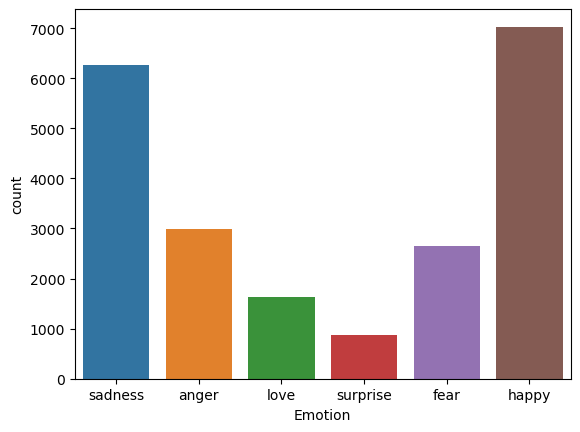

In [4]:
sns.countplot(x = "Emotion", data = df)

In [5]:
# upsample surprise
n_surp_sample = 1000
surp = df[df["Emotion"] == "surprise"]
surp_upsample = resample(surp, random_state = 35, n_samples=n_surp_sample, replace = True)

# upsample love
n_love_sample = 500
love = df[df["Emotion"] == "love"]
love_upsample = resample(love, random_state = 35, n_samples=n_love_sample, replace = True)

df = pd.concat([df, surp_upsample, love_upsample])

<AxesSubplot:xlabel='Emotion', ylabel='count'>

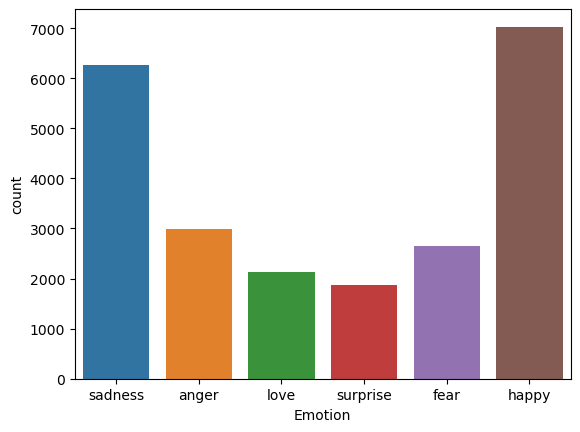

In [6]:
sns.countplot(x = "Emotion", data = df)

<AxesSubplot:>

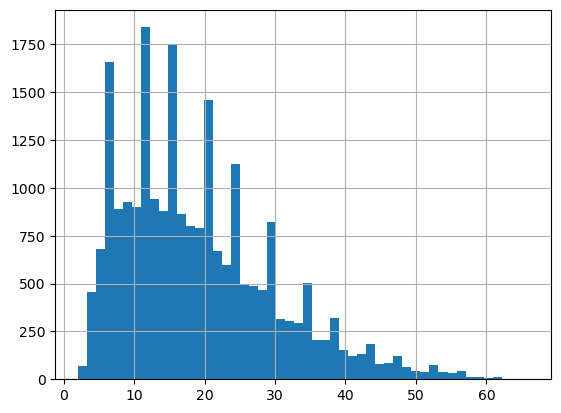

In [7]:
seq_len = (len(i.split()) for i in df['Text'])
pd.Series(seq_len).hist(bins = 50)

In [8]:
encoder = OneHotEncoder()
X = np.array(df.Text)
y = encoder.fit_transform(np.array(df.Emotion).reshape(-1,1)).toarray()

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train)

In [10]:
tokenize_data = Tokenizer(oov_token='<UNK>', split=" ")
tokenize_data.fit_on_texts(X_train)

In [11]:
tokenize_train = tokenize_data.texts_to_sequences(X_train)
vec_train = pad_sequences(tokenize_train, padding="post", maxlen=50)

tokenize_val = tokenize_data.texts_to_sequences(X_val)
vec_val = pad_sequences(tokenize_val, padding="post", maxlen=50)

vocab_size = len(tokenize_data.word_index) + 1

In [12]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [13]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=50))
model.add(Bidirectional(LSTM(units=256, dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(units=256, dropout=0.2, return_sequences=True)))
model.add(GlobalAveragePooling1D())
model.add(Dense(units=512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(units=512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(units=256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(units=128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(units=6, activation='softmax'))

opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 128)           2210432   
                                                                 
 bidirectional (Bidirectiona  (None, 50, 512)          788480    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 50, 512)          1574912   
 nal)                                                            
                                                                 
 global_average_pooling1d (G  (None, 512)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                        

In [14]:
his = model.fit(x=vec_train, y=y_train, batch_size=128, epochs=30, validation_data=(vec_val, y_val))

Epoch 1/30
146/146 [==============================] - 38s 161ms/step - loss: 1.8590 - accuracy: 0.2478 - val_loss: 1.6974 - val_accuracy: 0.2704
Epoch 2/30
146/146 [==============================] - 14s 93ms/step - loss: 1.3567 - accuracy: 0.4938 - val_loss: 1.3253 - val_accuracy: 0.4756
Epoch 3/30
146/146 [==============================] - 10s 70ms/step - loss: 0.9755 - accuracy: 0.6146 - val_loss: 2.4585 - val_accuracy: 0.4132
Epoch 4/30
146/146 [==============================] - 10s 67ms/step - loss: 0.6836 - accuracy: 0.7276 - val_loss: 2.0439 - val_accuracy: 0.5365
Epoch 5/30
146/146 [==============================] - 9s 65ms/step - loss: 0.4153 - accuracy: 0.8510 - val_loss: 2.4868 - val_accuracy: 0.4969
Epoch 6/30
146/146 [==============================] - 9s 58ms/step - loss: 0.2460 - accuracy: 0.9191 - val_loss: 1.0061 - val_accuracy: 0.6870
Epoch 7/30
146/146 [==============================] - 8s 57ms/step - loss: 0.1518 - accuracy: 0.9503 - val_loss: 1.2264 - val_accuracy: 0